In [118]:
# Delphi PID exploration!  Here we aim to study reco PID performance

In [119]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import ROOT

uproot.default_library = "np"

In [120]:
file = uproot.open("nanoaod_kk2f4146_qqpy_91.25_40545.sdst_ttree.root")
tree = file["t"]

In [121]:
tree.keys()

['Btag_probAllIP',
 'Btag_probNegIP',
 'Btag_probPosIP',
 'Btag_thrustVector',
 'Btag_thrustVector/fCoordinates',
 'Btag_thrustVector/fCoordinates/fCoordinates.fX',
 'Btag_thrustVector/fCoordinates/fCoordinates.fY',
 'Btag_thrustVector/fCoordinates/fCoordinates.fZ',
 'Btag_thrustVector_fCoordinates',
 'Btag_thrustVector_fCoordinates/fX',
 'Btag_thrustVector_fCoordinates/fY',
 'Btag_thrustVector_fCoordinates/fZ',
 'Btag_thrustVector_fCoordinates_fX',
 'Btag_thrustVector_fCoordinates_fY',
 'Btag_thrustVector_fCoordinates_fZ',
 'Dedx_error',
 'Dedx_gapWires',
 'Dedx_nrVDHits',
 'Dedx_nrWires',
 'Dedx_value',
 'Dedx_valueVD',
 'Dedx_width',
 'Elid_gammaConversion',
 'Elid_partIdx',
 'Elid_px',
 'Elid_py',
 'Elid_pz',
 'Elid_tag',
 'Event_DSTType',
 'Event_chargedMult',
 'Event_chargedMultT4',
 'Event_cmEnergy',
 'Event_date',
 'Event_evtNumber',
 'Event_fillNumber',
 'Event_hadronTagT4',
 'Event_magField',
 'Event_neutralMult',
 'Event_runNumber',
 'Event_time',
 'Event_totalChargedEnergy'

In [122]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Btag_probAllIP       | RVec<float>              | AsJagged(AsDtype('>f4'), he...
Btag_probNegIP       | RVec<float>              | AsJagged(AsDtype('>f4'), he...
Btag_probPosIP       | RVec<float>              | AsJagged(AsDtype('>f4'), he...
Btag_thrustVector    | ROOT::Math::Displacem... | AsGroup(<TBranchElement 'Bt...
Btag_thrustVector... | ROOT::Math::Cartesian... | AsGroup(<TBranchElement 'fC...
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | ROOT::Math::Cartesian... | AsGroup(<TBranchElement 'Bt...
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | float                    | AsDtype('>f4')
Btag_thrustVector... | floa

In [123]:
# Some helper functions

In [124]:
def Magnitude(px, py, pz):
    return np.sqrt(px * px + py * py + pz * pz)

def DotProduct(px1, py1, pz1, px2, py2, pz2):
    return px1 * px2 + py1 * py2 + pz1 * pz2

def CosAngle(px1, py1, pz1, px2, py2, pz2):
    return DotProduct(px1, py1, pz1, px2, py2, pz2) / Magnitude(px1, py1, pz1) / Magnitude(px2, py2, pz2)

def GetAngle(px1, py1, pz1, px2, py2, pz2):
    Value = CosAngle(px1, py1, pz1, px2, py2, pz2)
    if Value < -1:
        Value = -1
    if Value > 1:
        Value = 1
    return np.arccos(Value)

In [125]:
# Now we massage things so that it is simpler to navigate.  We focus on one particle type to start with

In [129]:
GenAlias           = {}
GenAlias["px"]     = "GenPart_vector/GenPart_vector.fCoordinates.fX"
GenAlias["py"]     = "GenPart_vector/GenPart_vector.fCoordinates.fY"
GenAlias["pz"]     = "GenPart_vector/GenPart_vector.fCoordinates.fZ"
GenAlias["E"]      = "GenPart_vector/GenPart_vector.fCoordinates.fT"
GenAlias["mass"]   = "GenPart_mass"
GenAlias["id"]     = "GenPart_pdgId"
GenAlias["parent"] = "GenPart_parentIdx"
GenAlias["status"] = "GenPart_status"

AllSelection = "(status == 4)"
PionSelection = "(status == 1) & ((id == 211) | (id == -211))"
KaonSelection = "(status == 1) & ((id == 321) | (id == -321))"

Gen = tree.arrays(["px", "py", "pz", "E", "mass", "id", "status", "parent"], aliases = GenAlias)

SimAlias = {}
SimAlias["px"]     = "SimPart_fourMomentum/SimPart_fourMomentum.fCoordinates.fX"
SimAlias["py"]     = "SimPart_fourMomentum/SimPart_fourMomentum.fCoordinates.fY"
SimAlias["pz"]     = "SimPart_fourMomentum/SimPart_fourMomentum.fCoordinates.fZ"
SimAlias["E"]      = "SimPart_fourMomentum/SimPart_fourMomentum.fCoordinates.fT"
SimAlias["genid"]  = "SimPart_genIdx"
SimAlias["partid"] = 'SimPart_partIdx'
SimAlias["id"]     = 'SimPart_pdgId'
SimAlias["in_id"]  = 'SimPart_originVtxIdx'
SimAlias["out_id"] = 'SimPart_decayVtxIdx'

Sim = tree.arrays(["px", "py", "pz", "E", "genid", "partid", "id", "in_id", "out_id"], aliases = SimAlias)

# SimVAlias = {}
# SimVAlias["in_id"]  = 'SimVtx_incomingIdx'
# SimVAlias["nout"]   = 'SimVtx_nOut'
# SimVAlias["out_id"] = 'SimVtx_outgoingIdx'
# SimVAlias["x"]      = 'SimVtx_position_fCoordinates_fX'
# SimVAlias["y"]      = 'SimVtx_position_fCoordinates_fY'
# SimVAlias["z"]      = 'SimVtx_position_fCoordinates_fZ'

# SimV = tree.arrays(["x", "y", "z", "in_id", "nout", "out_id"], aliases = SimVAlias)

RecoAlias           = {}
RecoAlias["px"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fX"
RecoAlias["py"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fY"
RecoAlias["pz"]     = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fZ"
RecoAlias["E"]      = "Part_fourMomentum/Part_fourMomentum.fCoordinates.fT"
RecoAlias["charge"] = "Part_charge"
RecoAlias["id"]     = "Part_pdgId"

Reco = tree.arrays(["px", "py", "pz", "E", "charge", "id"], "charge != 0", aliases = RecoAlias)

PIDAlias = {}
PIDAlias["dedx"]        = "Dedx_valueVD"
PIDAlias["ElectronTag"] = 'Haidc_electronTag'
PIDAlias["HeavyTag"]    = 'Haidc_heavyTag'
PIDAlias["KaonTag"]     = 'Haidc_kaonTag'
PIDAlias["PionTag"]     = 'Haidc_pionTag'
PIDAlias["ProtonTag"]   = 'Haidc_protonTag'
PIDAlias["Selection"]   = 'Haidc_selectionFlag'
PIDAlias["QKaonTag"]    = "Haid_kaonCombined"
PIDAlias["QProtonTag"]  = "Haid_protonCombined"

PID = tree.arrays(["dedx", "ElectronTag", "HeavyTag", "PionTag", "KaonTag", "ProtonTag", "Selection", "QKaonTag", "QProtonTag"], aliases = PIDAlias)

EventAlias = {}
EventAlias["Ecm"]   = "Event_cmEnergy"
EventAlias["Nch"]   = 'Event_chargedMult'
EventAlias["Run"]   = "Event_runNumber"
EventAlias["Event"] = "Event_evtNumber"
EventAlias["Fill"]  = "Event_fillNumber"

Event = tree.arrays(["Ecm", "Nch", "Run", "Event", "Fill"], aliases = EventAlias)

In [130]:
def Print(array):
    # print(array.reshape(-1, 10))
    size = len(array)
    count = 0
    while count < size:
        print(array[count:count+10])
        count = count + 10
    print('--')

EventID = 10

print("Number of Gen:", len(Gen[EventID].id))
Print(np.array(Gen[EventID].id))
Print(np.array(Gen[EventID].status))
Print(np.array(Gen[EventID].parent))

print("Number of SimTracks:", len(Sim[EventID].id))
Print(np.array(Sim[EventID].genid))
Print(np.array(Sim[EventID].partid))
Print(np.array(Sim[EventID].id))
Print(np.array(Sim[EventID].in_id))
Print(np.array(Sim[EventID].out_id))

# print("Number of SimVertex:", len(SimV[EventID].in_id))
# Print(np.array(SimV[EventID].in_id))
# Print(np.array(SimV[EventID].nout))
# Print(np.array(SimV[EventID].out_id))

Number of Gen: 109
[ 11 -11  23   5  -5  94   5  -5   5  21]
[-5 21  5 21 21 21 -5 21  5 21]
[   21    21    21    21    -5    92  -513  -215 10211   223]
[ 2114 -2114   513  -511    22  -213   111   221   211   211]
[ -211   111  2212  -211 -2112   111   511    22   413  -431]
[20113  -211   111    22    22    22    22    22    22    22]
[    22     12    -11 -10413    421    211     13    -14    333    213]
[-211   22   22 -413  111 -311  111  130  310  211]
[ 111 -411  111   22   22  310   22   22   22   22]
[   311 -20213     22     22    310   -213    111   -211    111     22]
[22 22 22  0  0  0  0  0  0]
--
[21 21 21 14 14 11 14 14 14 14]
[14 13 13 13 13 13 13 13 12 12]
[12 12 12 12 11 11 11 11 11 11]
[11 11 11 11  1 11 11 11  1  1]
[ 1 11  1  1  1 11 11  1 11 11]
[11  1 11  1  1  1  1  1  1  1]
[ 1  1  1 11 11  1  1  1 11 11]
[ 1  1  1 11 11 11 11  1  4  1]
[11 11 11  1  1  4  1  1  1  1]
[11 11  1  1  4 11 11  1 11  1]
[ 1  1  1 21 21 21 21 21 21]
--
[-1 -1 -1  2  2  3  5  5  6

In [74]:
print('dedx branch sizes', len(tree["Dedx_valueVD"].array()[0]))
print('reco particle count', len(tree["Part_pdgId"].array()[0]))
print('charged reco particle count', len(Reco["id"][0]))
print('rich detector sizes', len(tree["Rich_thel"].array()[0]))
print('hadron ID c sizes', len(tree['Haidc_heavyTag'].array()[0]))

dedx branch sizes 14
reco particle count 29
charged reco particle count 14
rich detector sizes 14
hadron ID c sizes 14


In [13]:
print("PIDs", set.union(*map(set, Gen.id)))

PIDs {-2112, 321, 2112, 130, 11, 12, 13, 14, 16, 211, 22, -2212, 2212, -211, -16, -14, -13, -12, -11, -321}


In [75]:
# Let's try to do the full course matching then!

In [136]:
HKsSimDecayCount = ROOT.TH1D("HKsSimDecayCount", "", 16, 0, 16)
HPhiGenDecayCount = ROOT.TH1D("HPhiGenDecayCount", "", 16, 0, 16)

NEvent = len(Gen)

for iE in range(NEvent):
    NGen = len(Gen[iE].px)
    NSim = len(Sim[iE].id)
    NReco = len(Reco[iE].px)

    # Temporarily copy things out of awkward array to make it run faster
    GenPx     = np.array(Gen[iE].px)
    GenPy     = np.array(Gen[iE].py)
    GenPz     = np.array(Gen[iE].pz)
    GenE      = np.array(Gen[iE].E)
    GenID     = np.array(Gen[iE].id)
    GenStatus = np.array(Gen[iE].status)
    GenParent = np.array(Gen[iE].parent)

    SimPx    = np.array(Sim[iE].px)
    SimPy    = np.array(Sim[iE].py)
    SimPz    = np.array(Sim[iE].pz)
    SimE     = np.array(Sim[iE].E)
    SimGenID = np.array(Sim[iE].genid)
    SimID    = np.array(Sim[iE].id)
    SimIn    = np.array(Sim[iE].in_id)
    SimOut   = np.array(Sim[iE].out_id)
    
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    # Loop through status = 4 particles to find the Ks0
    GenStatusFour = [x for x in range(NGen) if GenStatus[x] == 4]
    
    for iG in GenStatusFour:
        SimIndex = [x for x in range(NSim) if iG == SimGenID[x]]

        if len(SimIndex) != 1:
            print("Error! Matched sim count =", len(SimIndex))
        
        DecayIndex = [x for x in range(NSim) if SimOut[SimIndex[0]] == SimIn[x]]

        # print(iG)
        # print(SimIndex)
        # print(SimOut[SimIndex[0]])
        # print(DecayIndex)

        if GenID[iG] == 310:
            AllPx = np.sum(SimPx[DecayIndex])
            AllPy = np.sum(SimPy[DecayIndex])
            AllPz = np.sum(SimPz[DecayIndex])
            AllE = np.sum(SimE[DecayIndex])

            Conserve = np.abs(GenPx[iG] - AllPx) < 0.01
            Conserve = Conserve and np.abs(GenPy[iG] - AllPy) < 0.01
            Conserve = Conserve and np.abs(GenPz[iG] - AllPz) < 0.01
            Conserve = Conserve and np.abs(GenE[iG] - AllE) < 0.01

            # 41 and -41 are pi+ and pi- in internal Delphi
            if Conserve == True and 41 in SimID[DecayIndex] and -41 in SimID[DecayIndex]:
                HKsSimDecayCount.Fill(len(DecayIndex))

                if len(DecayIndex) > 2:
                    print(SimID[DecayIndex])

    # Find the phi's (they are status 11!)
    PhiIndex = [x for x in range(NGen) if GenID[x] == 333]
    
    for iG in PhiIndex:

        DecayIndex = [x for x in range(NGen) if GenParent[x] == iG]

        # Check Kaons
        if 321 in GenID[DecayIndex] and -321 in GenID[DecayIndex]:
            HPhiGenDecayCount.Fill(len(DecayIndex))

            if len(DecayIndex) > 2:
                print(GenID[DecayIndex])


Warning in <TROOT::Append>: Replacing existing TH1: HKsSimDecayCount (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: HPhiSimDecayCount (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


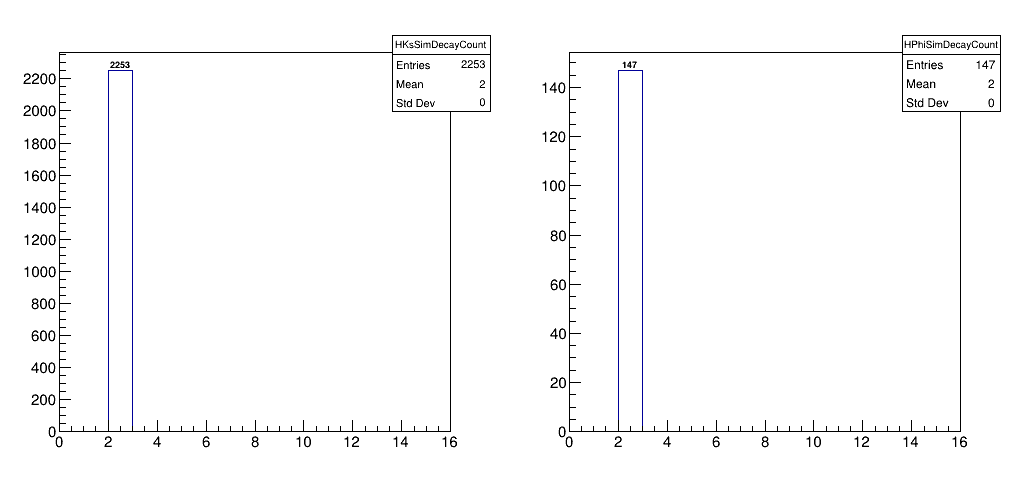

In [137]:
Canvas = ROOT.TCanvas("Canvas", "", 1024, 512)
Canvas.Divide(2)

Canvas.cd(1)
HKsSimDecayCount.Draw("hist text00")

Canvas.cd(2)
HPhiGenDecayCount.Draw("hist text00")

Canvas.Draw()

In [14]:
# Doing the simple-minded matching for now

In [141]:
SimMatch = []
SimAngle = []

for iE, entry in enumerate(Sim):
    NGen = len(Gen[iE].px)
    NSim = len(Sim[iE].id)
    NReco = len(Reco[iE].px)

    # Temporarily copy things out of awkward array to make it run faster
    GenPx     = np.array(Gen[iE].px)
    GenPy     = np.array(Gen[iE].py)
    GenPz     = np.array(Gen[iE].pz)
    GenE      = np.array(Gen[iE].E)
    GenID     = np.array(Gen[iE].id)
    GenStatus = np.array(Gen[iE].status)
    GenParent = np.array(Gen[iE].parent)

    SimPx    = np.array(Sim[iE].px)
    SimPy    = np.array(Sim[iE].py)
    SimPz    = np.array(Sim[iE].pz)
    SimE     = np.array(Sim[iE].E)
    SimGenID = np.array(Sim[iE].genid)
    SimID    = np.array(Sim[iE].id)
    SimIn    = np.array(Sim[iE].in_id)
    SimOut   = np.array(Sim[iE].out_id)
    
    RecoPx = np.array(Reco[iE].px)
    RecoPy = np.array(Reco[iE].py)
    RecoPz = np.array(Reco[iE].pz)

    MatchingIndex = np.full(NSim, -1.0)
    MatchingAngle = np.full(NSim, -1.0)
    
    # Loop through status = 4 particles to find the Ks0
    GenStatusFour = [x for x in range(NGen) if GenStatus[x] == 4]
    
    for iG in GenStatusFour:
        SimIndex = [x for x in range(NSim) if iG == SimGenID[x]]

        if len(SimIndex) != 1:
            print("Error! Matched sim count =", len(SimIndex))
        
        DecayIndex = [x for x in range(NSim) if SimOut[SimIndex[0]] == SimIn[x]]

        # print(iG)
        # print(SimIndex)
        # print(SimOut[SimIndex[0]])
        # print(DecayIndex)

        if GenID[iG] == 310:
            AllPx = np.sum(SimPx[DecayIndex])
            AllPy = np.sum(SimPy[DecayIndex])
            AllPz = np.sum(SimPz[DecayIndex])
            AllE = np.sum(SimE[DecayIndex])

            Conserve = np.abs(GenPx[iG] - AllPx) < 0.01
            Conserve = Conserve and np.abs(GenPy[iG] - AllPy) < 0.01
            Conserve = Conserve and np.abs(GenPz[iG] - AllPz) < 0.01
            Conserve = Conserve and np.abs(GenE[iG] - AllE) < 0.01

            # 41 and -41 are pi+ and pi- in internal Delphi
            if Conserve == True and 41 in SimID[DecayIndex] and -41 in SimID[DecayIndex]:

                for iS in DecayIndex:
                    BestIndex = -1
                    BestDistance = -1
                    for iR in range(NReco):
                        Distance = GetAngle(SimPx[iS], SimPy[iS], SimPz[iS], RecoPx[iR], RecoPy[iR], RecoPz[iR])
                        if BestIndex < 0 or BestDistance > Distance:
                            BestIndex = iR
                            BestDistance = Distance
                    MatchingIndex[iS] = BestIndex
                    MatchingAngle[iS] = BestDistance
    
    SimMatch.append(MatchingIndex)
    SimAngle.append(MatchingAngle)

In [152]:
HAngle = ROOT.TH1D("HAngle", ";Sim-reco matching angle;Counts", 100, 0, 1)

for iE in range(len(SimAngle)):
    NSim = len(Sim[iE].px)
    for iG in range(NSim):
        HAngle.Fill(SimAngle[iE][iG])

Warning in <TROOT::Append>: Replacing existing TH1: HAngle (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


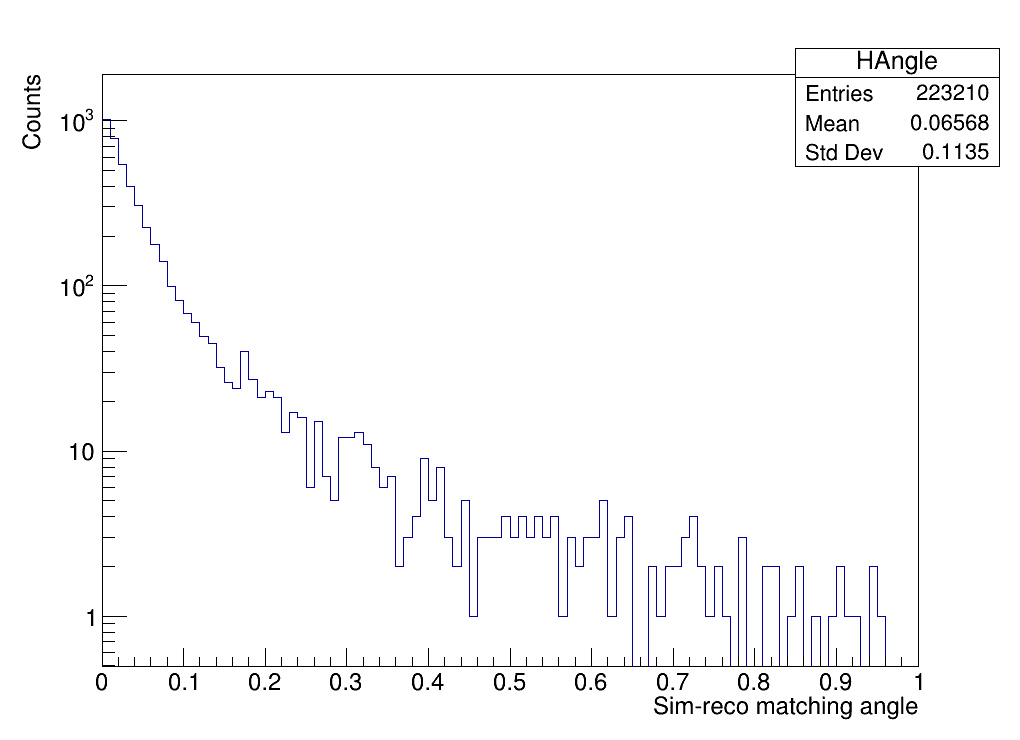

In [153]:
Canvas = ROOT.TCanvas("Canvas", "", 1024, 768)
Canvas.SetLogy()

HAngle.Draw()

Canvas.Draw()